In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from model import UNet
import matplotlib.pyplot as plt
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 100 
train_data_loader = DataLoader(train_data, batch_size = batch_size)
test_data_loader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_data_loader:
    print(X.shape)
    print(y.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1

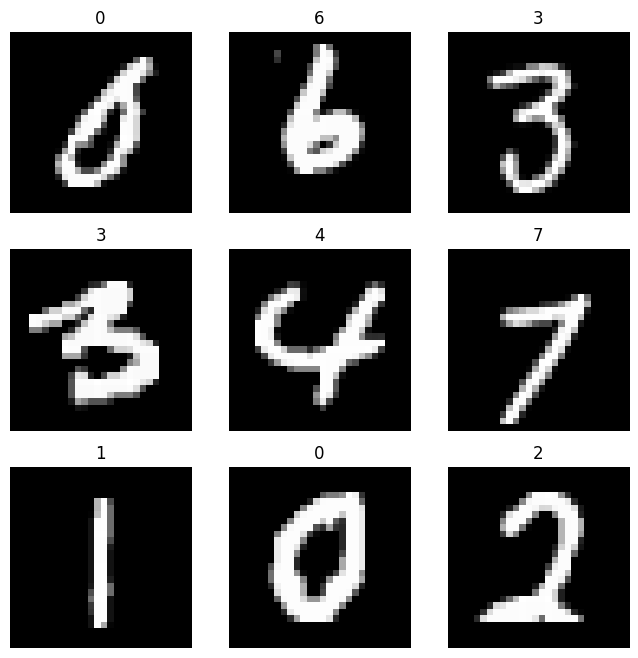

In [3]:
figure = plt.figure(figsize=(8,8))

cols, rows = 3,3

for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()

In [4]:
from model import UNet

model = UNet(1, 10).to(device)

In [5]:
print(model)

UNet(
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
for epoch in range(20):
    train(train_data_loader, model, loss_fn, optimizer)

loss: 2.382249  [  100/60000]
loss: 0.599665  [10100/60000]
loss: 0.458707  [20100/60000]
loss: 0.275282  [30100/60000]
loss: 0.164346  [40100/60000]
loss: 0.198263  [50100/60000]
loss: 0.207973  [  100/60000]
loss: 0.193424  [10100/60000]
loss: 0.199400  [20100/60000]
loss: 0.125057  [30100/60000]
loss: 0.071094  [40100/60000]
loss: 0.105533  [50100/60000]
loss: 0.146663  [  100/60000]
loss: 0.143760  [10100/60000]
loss: 0.150486  [20100/60000]
loss: 0.102231  [30100/60000]
loss: 0.047748  [40100/60000]
loss: 0.073087  [50100/60000]
loss: 0.112172  [  100/60000]
loss: 0.119819  [10100/60000]
loss: 0.122224  [20100/60000]
loss: 0.094222  [30100/60000]
loss: 0.037310  [40100/60000]
loss: 0.056248  [50100/60000]
loss: 0.089161  [  100/60000]
loss: 0.104383  [10100/60000]
loss: 0.102208  [20100/60000]
loss: 0.090594  [30100/60000]
loss: 0.031466  [40100/60000]
loss: 0.045696  [50100/60000]
loss: 0.073181  [  100/60000]
loss: 0.092395  [10100/60000]
loss: 0.087332  [20100/60000]
loss: 0.08

KeyboardInterrupt: 

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss, correct = 0,0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct/=size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
test(test_data_loader, model, loss_fn)

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.051056 



In [68]:
def save(model, file='./model'):
    torch.save(model.state_dict(),file)

In [69]:
save(model)

In [13]:
sample_idx = torch.randint(len(train_data), size= (1,)).item()

pred = model(train_data[sample_idx][0].view(1,1,28,28)).argmax(1).item()
truth = train_data[sample_idx][1]

print(f"Prediction: {pred}. Ground truth: {truth}")

Prediction: 5. Ground truth: 5


In [16]:
t = torch.ones(size=(3,2,))

In [17]:
t

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [18]:
n = t.numpy()

In [19]:
n

array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)

In [32]:
t.add_(2)

tensor([[12., 12.],
        [12., 12.],
        [12., 12.]])

In [33]:
n

array([[12., 12.],
       [12., 12.],
       [12., 12.]], dtype=float32)